In [1]:
import tensorflow as tf

2023-08-09 15:52:55.981236: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-09 15:52:56.010426: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 15:52:56.566959: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.13.0'

In [3]:
import glob
# import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
# from tensorflow.python.keras import layers
from tensorflow.keras import layers
import time
import nibabel as nib
from tqdm import tqdm
import gc

from IPython import display

import model

In [4]:
subjects = [ f.name for f in os.scandir('./Data') if f.is_dir() and f.name != '.ipynb_checkpoints']

print(subjects)

['390645', '545345', '106016', '120111', '101915', '351938', '705341']


In [5]:
subjects_lr = []
subjects_hr = []
subjects_masks = []

for subj in subjects:

    h4_imgs = []
    h4_imgs_lr = []
    dti_imgs = []
    dti_imgs_lr = []

    print("Loading Subject {}".format(subj))
    
    for i in range(1,9):
    
        dti_data = np.array(nib.load("Data/{}/T1w/Diffusion/dt_all_{}.nii".format(subj,i)).get_fdata())
        dti_data_lr = np.array(nib.load("Data/{}/T1w/Diffusion/dt_all_lowres_2_{}.nii".format(subj,i)).get_fdata())
    
        # if i > 1:
        #     dti_data[dti_imgs[0] < 0] = 0
        #     dti_data_lr[dti_imgs[0] < 0] = 0
    
        dti_imgs.append(dti_data)
        dti_imgs_lr.append(dti_data_lr)
    
        dti_data = None
        dti_data_lr = None
    
    for i in range(1,25):
    
        h4_data = np.array(nib.load("Data/{}/T1w/Diffusion/h4_all_{}.nii".format(subj,str(i).zfill(2))).get_fdata())
        h4_data_lr = np.array(nib.load("Data/{}/T1w/Diffusion/h4_all_lowres_2_{}.nii".format(subj,str(i).zfill(2))).get_fdata())
    
        # if i > 1:
        #     h4_data[h4_data[0] < 0] = 0
        #     h4_data_lr[h4_data[0] < 0] = 0
        
        h4_imgs.append(h4_data)
        h4_imgs_lr.append(h4_data_lr)
    
        h4_data = None
        h4_data_lr = None
    
    h4_imgs = np.array(h4_imgs).transpose((1,2,3,0))
    h4_imgs_lr = np.array(h4_imgs_lr).transpose((1,2,3,0))
    
    dti_imgs = np.array(dti_imgs).transpose((1,2,3,0))
    dti_imgs_lr = np.array(dti_imgs_lr).transpose((1,2,3,0))
    
    t1w = nib.load("Data/{}/T1w/Diffusion/t1w.nii".format(subj))
    
    t1w_data = np.array(t1w.get_fdata())
    
    t1w_data_format = np.concatenate(
        (t1w_data[::2,::2,::2, None], t1w_data[::2,::2,1::2, None],
         t1w_data[::2,1::2,::2, None], t1w_data[::2,1::2,1::2, None],
         t1w_data[1::2,::2,::2, None], t1w_data[1::2,::2,1::2, None],
         t1w_data[1::2,1::2,::2, None], t1w_data[1::2,1::2,1::2, None]),
        axis=-1)
    
    # lowres_input = np.concatenate((h4_imgs_lr[...,2:], dti_imgs_lr[...,2:], t1w_data_format), axis=-1)
    lowres_input = np.concatenate((h4_imgs_lr[...,2:], dti_imgs_lr[...,2:]), axis=-1)
    hires_output = h4_imgs[...,2:]
    
    mask = h4_imgs[...,0]

    subjects_lr.append(lowres_input)
    subjects_hr.append(hires_output)
    subjects_masks.append(mask)


Loading Subject 390645
Loading Subject 545345
Loading Subject 106016
Loading Subject 120111
Loading Subject 101915
Loading Subject 351938
Loading Subject 705341


In [6]:
len(subjects_masks)

7

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv3D(64, (5, 5, 5), strides=(2, 2, 2), padding='same',
                                     input_shape=[5, 5, 5, 22]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    # print(model.input_shape, model.output_shape)\n",

    model.add(layers.Conv3D(128, (5, 5, 5), strides=(2, 2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    # print(model.output_shape)\n",

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    print(model.output_shape)

    return model



# input_layer = tf.keras.Input(shape=(32, 32, 32, 36))
# output_layer = model.unet3d(input_layer, 36)

# generator = tf.keras.Model(input_layer, output_layer)
generator = model.simple_generator(28,22)
discriminator = model.simple_discriminator(22)

(None, 5, 5, 5, 22)
(None, 1)


2023-08-09 15:53:50.571928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-09 15:53:50.685120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


(1, 5, 5, 5, 22)


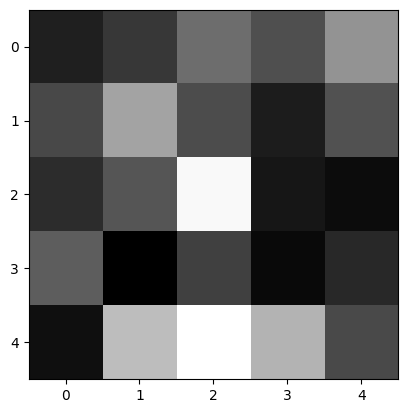

In [11]:
noise = tf.random.normal([1,11,11,11,28])
generated_image = generator(noise, training=False)

print(generated_image.shape)

plt.imshow(generated_image[0, :, :, 0, 0], cmap='gray')

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
checkpoint_dir = './training_checkpoints_unet'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [15]:
@tf.function
def train_step(lr_patch, hr_patch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(lr_patch, training=True)

      real_output = discriminator(hr_patch, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [16]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    print("Epoch: {}".format(epoch+1))


    mean_g_loss = 0.0
    mean_d_loss = 0.0
      
    for patch in tqdm(dataset):

      # lr_patch = lr_patches[p][None,...]

      # hr_patch = hr_patches[p][None,...]

      lr_patch = patch[0][None,...]
      hr_patch = patch[1][None,...]
        
      g_loss, d_loss = train_step(lr_patch, hr_patch)

      mean_g_loss = mean_g_loss + g_loss
      mean_d_loss = mean_d_loss + d_loss
      
    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    # generate_and_save_images(generator,
    #                          epoch + 1,
    #                          seed)

    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Generator Loss is {}'.format(float(mean_g_loss/len(dataset))))
    print('Discriminator Loss is {}'.format(float(mean_d_loss/len(dataset))))
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator,
  #                          epochs,
  #                          seed)

In [17]:
# subjects_lr
# subjects_hr
# subjects_masks

In [18]:
(xsize, ysize, zsize, comp) = subjects_lr[0].shape

e_or_o = 1

p_size_i = 5
p_size_o = 2

# split_indices = [(i, j, k)
#                  for k in np.arange(p_size_i+1,zsize-p_size_i+1,2*p_size_o+1)       
#                  for j in np.arange(p_size_i+1,ysize-p_size_i+1,2*p_size_o+1)
#                  for i in np.arange(p_size_i+1,xsize-p_size_i+1,2*p_size_o+1)
#                 ]

split_indices = [(i, j, k)
                 for k in np.arange(p_size_i+1,zsize-p_size_i+e_or_o,2*p_size_o+e_or_o)       
                 for j in np.arange(p_size_i+1,ysize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                 for i in np.arange(p_size_i+1,xsize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                ]

sel_indices = []

for s in range(len(subjects_lr)):
    for (i, j, k) in split_indices:
        ipatch_mask = subjects_masks[s][
            i - p_size_o - e_or_o : i + p_size_o,
            j - p_size_o - e_or_o : j + p_size_o,
            k - p_size_o - e_or_o : k + p_size_o]
    
        if np.max(ipatch_mask) >= 0:
            sel_indices.append((s,i,j,k))

sel_indices = np.array(sel_indices)

In [19]:
sel_indices[np.where(sel_indices[:,0]==0),1:].squeeze()

array([[ 46,  51,  11],
       [ 51,  51,  11],
       [ 56,  51,  11],
       ...,
       [ 91,  96, 111],
       [ 86, 101, 111],
       [ 91, 101, 111]])

In [20]:
print(len(sel_indices))

50697


In [21]:
# lr_patches = np.array([lowres_input[
#                        valid_indices[n,0]-2:valid_indices[n,0]+3,
#                        valid_indices[n,1]-2:valid_indices[n,1]+3,
#                        valid_indices[n,2]-2:valid_indices[n,2]+3, :]
#                        for n in choice_indices])

# hr_patches = np.array([hires_output[
#                        valid_indices[n,0]-2:valid_indices[n,0]+3,
#                        valid_indices[n,1]-2:valid_indices[n,1]+3,
#                        valid_indices[n,2]-2:valid_indices[n,2]+3, :]
#                        for n in choice_indices])

In [22]:
for s in range(7):
    print(s)

0
1
2
3
4
5
6


In [ ]:
for s in range(7):

    print("Subject {}".format(s+1))

    lr_patches = np.array([subjects_lr[s][
                                i - p_size_i - 1 : i + p_size_i,
                                j - p_size_i - 1 : j + p_size_i,
                                k - p_size_i - 1 : k + p_size_i, :]
                           for (i,j,k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze()])
    
    hr_patches = np.array([subjects_hr[s][
                                i - p_size_o - e_or_o : i + p_size_o,
                                j - p_size_o - e_or_o : j + p_size_o,
                                k - p_size_o - e_or_o : k + p_size_o, :]
                           for (i,j,k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze()])

# lr_patches = np.array([subjects_lr[s][
#                             i - p_size_i - e_or_o : i + p_size_i,
#                             j - p_size_i - e_or_o : j + p_size_i,
#                             k - p_size_i - e_or_o : k + p_size_i, :]
#                        # for (i,j,k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze()])
#                        for (s,i,j,k) in sel_indices])

# hr_patches = np.array([subjects_hr[s][
#                             i - p_size_o - e_or_o : i + p_size_o,
#                             j - p_size_o - e_or_o : j + p_size_o,
#                             k - p_size_o - e_or_o : k + p_size_o, :]
#                        # for (i,j,k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze()])
#                        for (s,i,j,k) in sel_indices])

    dataset = tf.data.Dataset.from_tensor_slices((lr_patches, hr_patches))
    
    train(dataset, 50)

Subject 1
Epoch: 1


  0%|                                                  | 0/6698 [00:00<?, ?it/s]2023-08-09 15:54:05.528898: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7faf72d1f180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-09 15:54:05.528920: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-08-09 15:54:05.532581: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-09 15:54:05.700758: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████████████████████████████████| 6698/6698 [00:46<00:00, 142.64it/s]


Generator Loss is 3.794128656387329
Discriminator Loss is 0.4125991761684418
Time for epoch 1 is 46.97360706329346 sec
Epoch: 2


100%|██████████████████████████████████████| 6698/6698 [00:36<00:00, 181.94it/s]


Generator Loss is 5.453303337097168
Discriminator Loss is 0.16570453345775604
Time for epoch 2 is 36.816126585006714 sec
Epoch: 3


100%|██████████████████████████████████████| 6698/6698 [00:46<00:00, 142.89it/s]


Generator Loss is 5.7815775871276855
Discriminator Loss is 0.13743914663791656
Time for epoch 3 is 46.879265785217285 sec
Epoch: 4


100%|██████████████████████████████████████| 6698/6698 [00:51<00:00, 130.69it/s]


Generator Loss is 6.057384967803955
Discriminator Loss is 0.10834485292434692
Time for epoch 4 is 51.254565715789795 sec
Epoch: 5


100%|██████████████████████████████████████| 6698/6698 [00:55<00:00, 121.51it/s]


Generator Loss is 6.512029647827148
Discriminator Loss is 0.10350717604160309
Time for epoch 5 is 55.43704581260681 sec
Epoch: 6


100%|██████████████████████████████████████| 6698/6698 [00:34<00:00, 192.14it/s]


Generator Loss is 6.340606212615967
Discriminator Loss is 0.11248569935560226
Time for epoch 6 is 34.86279916763306 sec
Epoch: 7


100%|██████████████████████████████████████| 6698/6698 [00:42<00:00, 158.86it/s]


Generator Loss is 6.765336990356445
Discriminator Loss is 0.10387341678142548
Time for epoch 7 is 42.16503047943115 sec
Epoch: 8


100%|██████████████████████████████████████| 6698/6698 [00:33<00:00, 197.21it/s]


Generator Loss is 6.647307872772217
Discriminator Loss is 0.11321723461151123
Time for epoch 8 is 33.96835803985596 sec
Epoch: 9


100%|██████████████████████████████████████| 6698/6698 [00:40<00:00, 164.42it/s]


Generator Loss is 6.7939043045043945
Discriminator Loss is 0.09943915158510208
Time for epoch 9 is 40.74214506149292 sec
Epoch: 10


100%|██████████████████████████████████████| 6698/6698 [00:50<00:00, 132.58it/s]


Generator Loss is 6.615784168243408
Discriminator Loss is 0.11024005711078644
Time for epoch 10 is 50.79148316383362 sec
Epoch: 11


100%|██████████████████████████████████████| 6698/6698 [00:57<00:00, 115.70it/s]


Generator Loss is 6.979010105133057
Discriminator Loss is 0.09481122344732285
Time for epoch 11 is 57.90092420578003 sec
Epoch: 12


100%|██████████████████████████████████████| 6698/6698 [00:54<00:00, 123.96it/s]


Generator Loss is 7.136475086212158
Discriminator Loss is 0.09960895031690598
Time for epoch 12 is 54.0384783744812 sec
Epoch: 13


100%|██████████████████████████████████████| 6698/6698 [00:53<00:00, 124.10it/s]


Generator Loss is 6.947943687438965
Discriminator Loss is 0.10135313868522644
Time for epoch 13 is 53.97526550292969 sec
Epoch: 14


100%|██████████████████████████████████████| 6698/6698 [00:52<00:00, 128.41it/s]


Generator Loss is 7.05593204498291
Discriminator Loss is 0.10642238706350327
Time for epoch 14 is 52.16620421409607 sec
Epoch: 15


100%|██████████████████████████████████████| 6698/6698 [00:39<00:00, 171.08it/s]


Generator Loss is 7.388725757598877
Discriminator Loss is 0.09946480393409729
Time for epoch 15 is 39.40572118759155 sec
Epoch: 16


100%|██████████████████████████████████████| 6698/6698 [00:34<00:00, 191.41it/s]


Generator Loss is 7.370419979095459
Discriminator Loss is 0.10821406543254852
Time for epoch 16 is 34.99680781364441 sec
Epoch: 17


100%|██████████████████████████████████████| 6698/6698 [00:50<00:00, 132.79it/s]


Generator Loss is 7.35758638381958
Discriminator Loss is 0.09851254522800446
Time for epoch 17 is 50.44231724739075 sec
Epoch: 18


100%|██████████████████████████████████████| 6698/6698 [00:54<00:00, 123.81it/s]


Generator Loss is 7.530090808868408
Discriminator Loss is 0.09329572319984436
Time for epoch 18 is 54.10393786430359 sec
Epoch: 19


100%|██████████████████████████████████████| 6698/6698 [00:39<00:00, 171.33it/s]


Generator Loss is 7.712492942810059
Discriminator Loss is 0.0832354873418808
Time for epoch 19 is 39.09783172607422 sec
Epoch: 20


100%|██████████████████████████████████████| 6698/6698 [00:34<00:00, 193.83it/s]


Generator Loss is 7.502912998199463
Discriminator Loss is 0.1016966924071312
Time for epoch 20 is 34.79910731315613 sec
Epoch: 21


100%|██████████████████████████████████████| 6698/6698 [00:36<00:00, 184.21it/s]


Generator Loss is 7.517480850219727
Discriminator Loss is 0.08946184813976288
Time for epoch 21 is 36.36531209945679 sec
Epoch: 22


100%|██████████████████████████████████████| 6698/6698 [00:42<00:00, 158.76it/s]


Generator Loss is 7.489590644836426
Discriminator Loss is 0.09947002679109573
Time for epoch 22 is 42.19058418273926 sec
Epoch: 23


100%|██████████████████████████████████████| 6698/6698 [01:04<00:00, 104.25it/s]


Generator Loss is 7.600326061248779
Discriminator Loss is 0.08552637696266174
Time for epoch 23 is 64.25510597229004 sec
Epoch: 24


100%|██████████████████████████████████████| 6698/6698 [00:55<00:00, 120.25it/s]


Generator Loss is 7.734912872314453
Discriminator Loss is 0.08744547516107559
Time for epoch 24 is 55.7032356262207 sec
Epoch: 25


100%|██████████████████████████████████████| 6698/6698 [00:47<00:00, 140.23it/s]


Generator Loss is 7.8983378410339355
Discriminator Loss is 0.0889589786529541
Time for epoch 25 is 48.00338315963745 sec
Epoch: 26


100%|██████████████████████████████████████| 6698/6698 [00:25<00:00, 259.16it/s]


Generator Loss is 7.503989219665527
Discriminator Loss is 0.10911465436220169
Time for epoch 26 is 25.84629511833191 sec
Epoch: 27


 72%|███████████████████████████▎          | 4809/6698 [00:25<00:11, 166.22it/s]

In [ ]:
result_image = np.zeros(hires_output.shape)

In [ ]:
result_image.shape

In [ ]:
# subjects_lr
# subjects_hr
# subjects_masks

for (i, j, k) in tqdm(sel_indices[np.where(sel_indices[:,0]==6),1:].squeeze()):

    lr_patch = subjects_lr[6][
                            i - p_size_i - e_or_o : i + p_size_i,
                            j - p_size_i - e_or_o : j + p_size_i,
                            k - p_size_i - e_or_o : k + p_size_i, :]

    generated_image = generator(lr_patch[None,...], training=False)

    result_image[i - p_size_o - e_or_o : i + p_size_o,
                 j - p_size_o - e_or_o : j + p_size_o,
                 k - p_size_o - e_or_o : k + p_size_o, :] = generated_image

result_image[subjects_masks[6] < 0] = 0
    

In [ ]:
zdim = 60
channel = 0

plt.imshow(subjects_lr[6][:,:,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(subjects_hr[6][:,:,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(result_image[:,:,zdim,channel], cmap='gray')

In [ ]:
plt.imshow(subjects_lr[6][40:80,60:120,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(subjects_hr[6][40:80,60:120,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(result_image[40:80,60:120,zdim,channel], cmap='gray')

In [ ]:
# generator.save_weights('Model/gen_weights')
# discriminator.save_weights('Model/disc_weights')

In [ ]:
generator.save('Model/generator_not1.keras')
discriminator.save('Model/discriminator_not1.keras')